# Text classification

In [2]:
import pandas as pd
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import GPT4AllEmbeddings
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
embeddings_ada_2 = OpenAIEmbeddings(model='text-embedding-ada-002')
embeddings_3_small = OpenAIEmbeddings(model='text-embedding-3-small')
embeddings_3_large = OpenAIEmbeddings(model='text-embedding-3-large')
gpt4all_embd = GPT4AllEmbeddings()

In [4]:
df = pd.read_csv('IMDB Dataset.csv')
sampled_df = df.sample(n=300, random_state=42)
sampled_df['sentiment'] = sampled_df['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)
sampled_df.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,1
9427,Not many television shows appeal to quite as m...,1
199,The film quickly gets to a major chase scene w...,0
12447,Jane Austen would definitely approve of this o...,1
39489,Expectations were somewhat high for me when I ...,0


In [5]:
labels = sampled_df['sentiment'].to_numpy()
review = sampled_df['review'].to_list()

In [6]:
# Generating dummy data for embeddings
embedding_1 = np.array([embeddings_ada_2.embed_query(text) for text in review])
embedding_2 = np.array([embeddings_3_small.embed_query(text) for text in review])
embedding_3 = np.array([embeddings_3_large.embed_query(text) for text in review])
embedding_4 = np.array([gpt4all_embd.embed_query(text) for text in review])

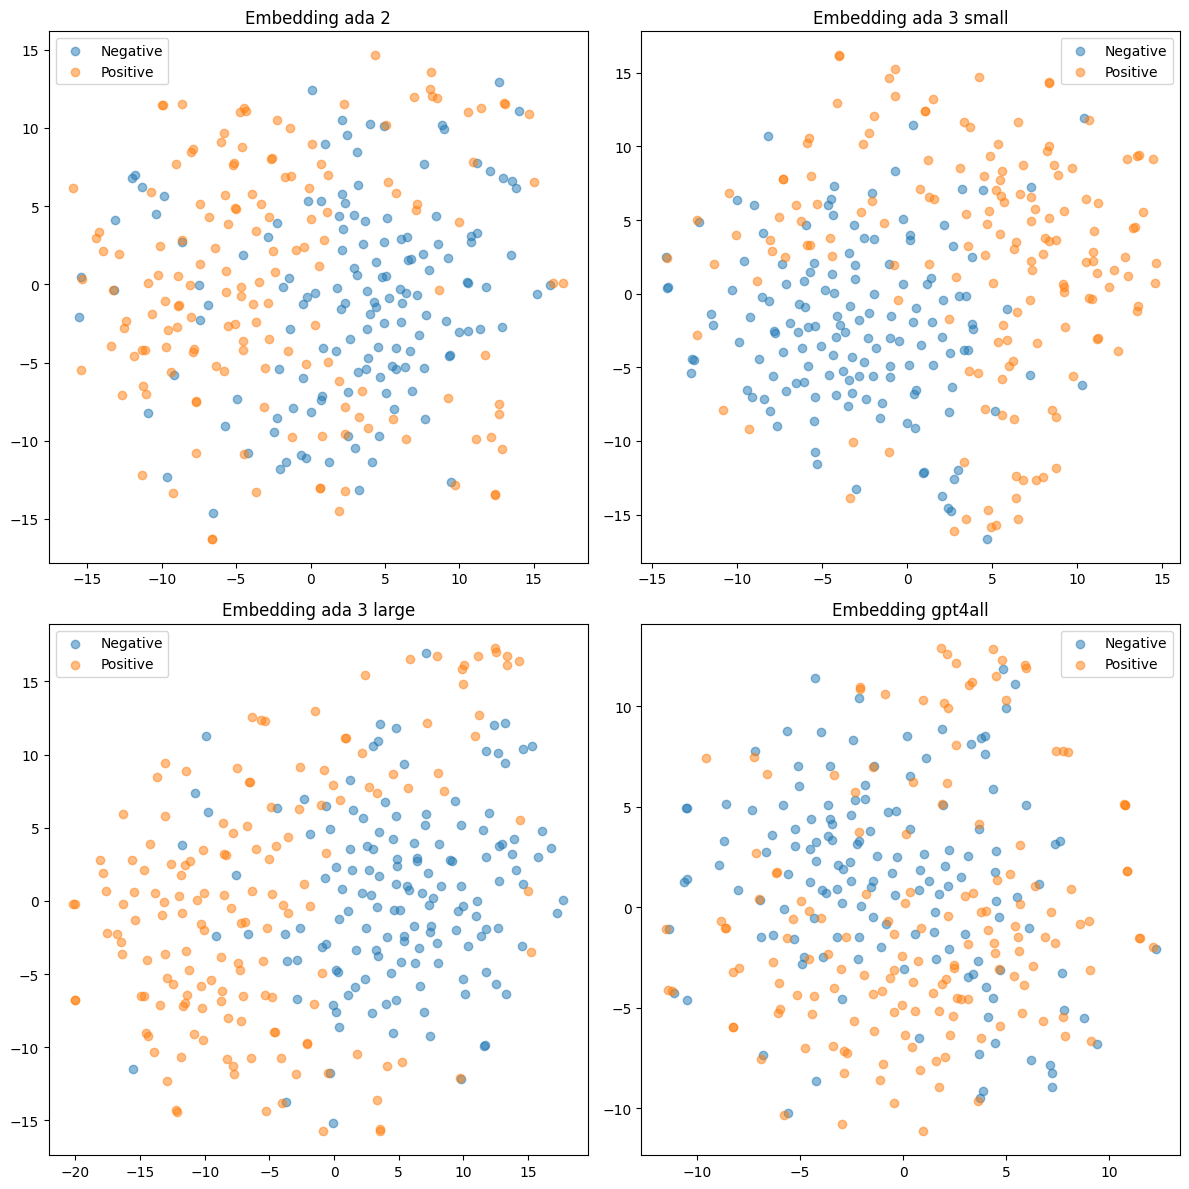

In [7]:
names=['ada 2', 'ada 3 small', 'ada 3 large', 'gpt4all']
# Function to perform t-SNE and plot
def tsne_plot(embeddings, labels):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    for i, embedding in enumerate(embeddings):
        # Perform t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(embedding)

        # Plot
        ax = axs[i//2, i%2]
        ax.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1], label='Negative', alpha=0.5)
        ax.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1], label='Positive', alpha=0.5)
        ax.set_title(f'Embedding {names[i]}')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Perform t-SNE and plot for all embeddings
tsne_plot([embedding_1, embedding_2, embedding_3, embedding_4], labels)

## Cosine similarity classifier

In [17]:
from sklearn.model_selection import train_test_split

np.random.seed(42)  # For reproducibility

# Split into train and test sets
embedding_1_train, embedding_1_test, label_train, label_test = train_test_split(embedding_1, labels, test_size=0.2, random_state=42)
embedding_2_train, embedding_2_test, _, _ = train_test_split(embedding_2, labels, test_size=0.2, random_state=42)
embedding_3_train, embedding_3_test, _, _ = train_test_split(embedding_3, labels, test_size=0.2, random_state=42)
embedding_4_train, embedding_4_test, _, _ = train_test_split(embedding_4, labels, test_size=0.2, random_state=42)

# Compute the central vector (mean vector) of the training set
embedding_1_central_vector = np.mean(embedding_1_train[label_train == 1], axis=0)
embedding_1_central_vector = embedding_1_central_vector / np.linalg.norm(embedding_1_central_vector)
embedding_2_central_vector = np.mean(embedding_2_train[label_train == 1], axis=0)
embedding_2_central_vector = embedding_2_central_vector / np.linalg.norm(embedding_2_central_vector)
embedding_3_central_vector = np.mean(embedding_3_train[label_train == 1], axis=0)
embedding_3_central_vector = embedding_3_central_vector / np.linalg.norm(embedding_3_central_vector)
embedding_4_central_vector = np.mean(embedding_4_train[label_train == 1], axis=0)
embedding_4_central_vector = embedding_4_central_vector / np.linalg.norm(embedding_4_central_vector)

(array([ 1.,  1.,  0.,  2.,  2.,  3.,  1.,  4.,  4.,  7., 11.,  8., 18.,
        17., 15.,  9.,  4.,  4.,  1.,  1.]),
 array([0.33240671, 0.35037586, 0.368345  , 0.38631415, 0.40428329,
        0.42225244, 0.44022158, 0.45819073, 0.47615987, 0.49412901,
        0.51209816, 0.5300673 , 0.54803645, 0.56600559, 0.58397474,
        0.60194388, 0.61991303, 0.63788217, 0.65585131, 0.67382046,
        0.6917896 ]),
 <BarContainer object of 20 artists>)

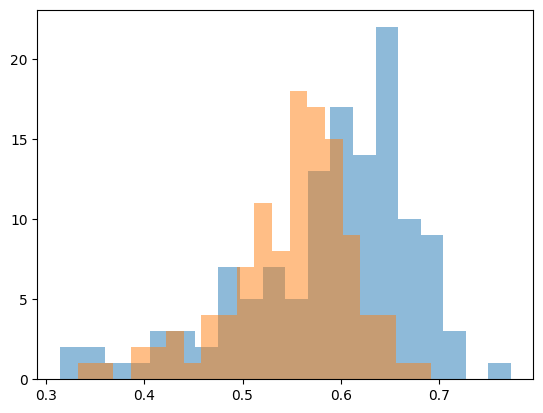

In [63]:
results = np.dot(embedding_3_train, embedding_3_central_vector)
plt.hist(results[label_train == 1], alpha = 0.5, bins=20)
plt.hist(results[label_train == 0], alpha = 0.5, bins=20)

Cosine similarity doesn't seem to perform and when we look at the distribution of cosine similarity between various vectors and the representative of the positive class we see that the distributions are mixed. Let's try the l2 norm as s measure of distance.

# Eucledian distance

(array([ 3.,  0.,  2.,  5.,  7., 10., 11.,  4., 13.,  9.,  7., 10.,  5.,
         3.,  5.,  5.,  6.,  1.,  5.,  2.]),
 array([0.42793003, 0.433287  , 0.43864398, 0.44400095, 0.44935792,
        0.45471489, 0.46007187, 0.46542884, 0.47078581, 0.47614278,
        0.48149975, 0.48685673, 0.4922137 , 0.49757067, 0.50292764,
        0.50828461, 0.51364159, 0.51899856, 0.52435553, 0.5297125 ,
        0.53506947]),
 <BarContainer object of 20 artists>)

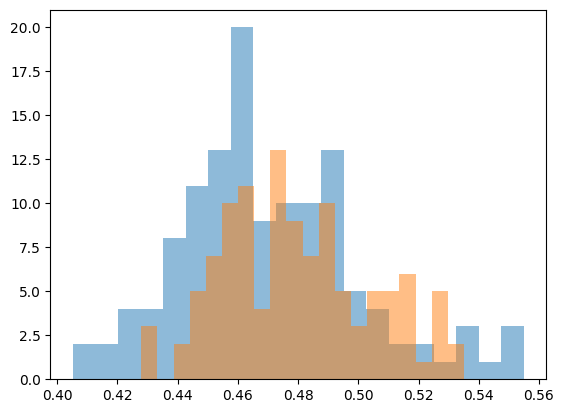

In [68]:
from scipy.spatial.distance import cdist

# Compute the central vector this time without normalization as we are computing the distance
embedding_1_central_vector = np.mean(embedding_1_train[label_train == 1], axis=0)
embedding_1_central_vector = embedding_1_central_vector
embedding_2_central_vector = np.mean(embedding_2_train[label_train == 1], axis=0)
embedding_2_central_vector = embedding_2_central_vector
embedding_3_central_vector = np.mean(embedding_3_train[label_train == 1], axis=0)
embedding_3_central_vector = embedding_3_central_vector
embedding_4_central_vector = np.mean(embedding_4_train[label_train == 1], axis=0)
embedding_4_central_vector = embedding_4_central_vector

# Compute the Euclidean distance between each training embedding and the central vector
results = cdist(embedding_1_train, embedding_1_central_vector.reshape(1, -1), 'euclidean').flatten()
plt.hist(results[label_train == 1], alpha = 0.5, bins=20)
plt.hist(results[label_train == 0], alpha = 0.5, bins=20)

This suffers from the same issue as the cosine classifier.

# SVM and KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import pandas as pd
import pickle

def train_evaluate_save(model, X_train, X_test, y_train, y_test, model_name, embedding_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Save the model
    with open(f'{model_name}_{embedding_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    return {'model_name': f'{model_name}_{embedding_name}', 'f1_score': f1}

results = []

training_embeds = [embedding_1_train, embedding_2_train, embedding_3_train, embedding_4_train] 
testing_embeds = [embedding_1_test, embedding_2_test, embedding_3_test, embedding_4_test]
for X_train, X_test, md in zip(training_embeds,,names):
    results.append(train_evaluate_save(KNeighborsClassifier(), X_train, X_test, label_train, label_test, "KNN", md))
    results.append(train_evaluate_save(SVC(), X_train, X_test, label_train, label_test, "SVM-rbf", md))
    results.append(train_evaluate_save(SVC(kernel='sigmoid'), X_train, X_test, label_train, label_test, "SVM-sigmoid", md))
    results.append(train_evaluate_save(SVC(kernel='linear'), X_train, X_test, label_train, label_test, "SVM-linear", md))

results_df = pd.DataFrame(results)
results_df.to_csv('embedding_models_scores.csv', index=False)


array([0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
      dtype=int64)